In [ ]:
!rm Iris.csv

In [ ]:
from google.colab import files
import numpy as np
import io

uploaded = files.upload()

f = io.BytesIO(uploaded['Iris.csv'])

Saving Iris.csv to Iris.csv


In [ ]:
# Zeramos o cursor para garantir que a leitura do arquivo inicie do início
f.seek(0)
# A variável lines é uma lista que contém as strings que representam cada linha do arquivo lido.
lines = f.readlines()

In [ ]:
X = np.zeros((len(lines)-1,4)) # 4 entradas
Y = np.zeros((len(lines)-1,3)) # 3 saídas (one-hot encoding)

# Categorias
cat = np.array(['Iris-setosa','Iris-versicolor','Iris-virginica'])

No laço abaixo populamos as matrizes `X` e `Y`.

In [ ]:
# Para cada linha do arquivo, exceto
# a primeira linha que é o cabeçalho
for i, line in enumerate(lines[1:]):

  # Aqui decodificamos a linha para transformar
  # de binário para caracteres ascii, e descartamos
  # o último caractere que representa uma nova linha
  s = line.decode()[:-1]

  # Aqui separamos os dados por vírgulas,
  # descartando o primeiro valor que é o id
  # pois usaremos i do laço como id.
  _,sl,sw,pl,pw,sp = s.split(',')

  # Transformamos as strings que representam
  # as dimensões de sépala e pétala para ponto
  # flutuante.
  sl = float(sl)
  sw = float(sw)
  pl = float(pl)
  pw = float(pw)
  
  # Aqui populamos as matrizes X e Y com os dados
  # coletados.
  X[i:] = np.array([sl,sw,pl,pw])
  Y[i:] = (cat == sp).astype('float') # Atenção para essa linha!

  # A última linha acima merece uma explicação mais longa:
  # Nessa linha fazemos um teste booleano, comparando cada
  # elemento do vetor cat com a string daquela linha do arquivo.
  # Para os elementos onde a comparação der verdadeiro, teremos
  # um booleano True, e para os elementos onde a comparação
  # der falso, teremos um booleano False. O resultado da comparação
  # do vetor cat com a string sp, na expressão cat == sp resulta
  # numa array booleana com mesmo formato que cat, mas com
  # valores booleanos True ou False em cada posição. O método
  # .astype('float') transforma o resultado em um array de float,
  # com 1.0 representando True e 0.0 representando False.
  # Então transformamos uma string como 'Iris-setosa' no vetor
  # [1.0, 0.0, 0.0] e uma string como 'Iris-versicolor' no vetor
  # [0.0, 1.0, 0.0] e assim por diante.

Nas linhas abaixo embaralhamos as amostras para não causar nenhum tipo de tendência no treinamento.

In [ ]:
import random

# Aqui criamos uma lista de índices
# embaralhados
indexes = list(range(150))
random.shuffle(indexes)

# Essa variável T indica quantas amostras
# serão usadas para treinamento. As demais
# serão usadas para validação
T = 140

# Aqui preparamos as matrizes dos pares
# de dados de treinamento e validação.
Xt = np.zeros((T,4))
Yt = np.zeros((T,3))
Xv = np.zeros((150-T,4))
Yv = np.zeros((150-T,3))

# Aqui preenchemos as matrizes com os
# respectivos valores
for i in range(0,T):
  Xt[i,:] = X[indexes[i],:]
  Yt[i,:] = Y[indexes[i],:]
for i in range(0,150-T):
  Xv[i,:] = X[indexes[T+i],:]
  Yv[i,:] = Y[indexes[T+i],:]

O código abaixo implementa a rede neural com o método de backpropagation.

In [ ]:
# Essa será a função de ativação
# utilizada
def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

# O código abaixo implementa uma rede
# neural ariticial estilo perceptron
# com 4 entradas, 8 neurônios escondidos
# e 3 saídas
class Perceptron:
  def __init__(self):

    # Pesos e biases da entrada para a camada
    # escondida
    self.Wh = np.random.random((8,4))*2.0 - 1.0
    self.bh = np.random.random((8,1))*2.0 - 1.0

    # Pesos e bieases da camada escondida para
    # a saída
    self.Wo = np.random.random((3,8))*2.0 - 1.0
    self.bo = np.random.random((3,1))*2.0 - 1.0

    # Esse será o passo de aprendizagem
    self.eta = 0.1

  def forward(self,x):

    # Essa função faz o cálculo da saída
    # da rede neural no sentido direto.

    # Essa linha garante que x tenha tamanho
    # de 4 linhas e 1 coluna
    x = np.reshape(x,(4,1))

    # Calcula a soma ponderada para a camada escondida
    # somado ao bias
    self.sh = np.dot(self.Wh,x) + self.bh

    # Função de ativação é aplicada à camada escondida
    self.zh = sigmoid(self.sh)

    # Calcula a soma ponderada para a camada de saída
    # somado ao bias
    self.so = np.dot(self.Wo,self.zh) + self.bo

    # Função de ativação é aplciada à camada de saída
    self.zo = sigmoid(self.so)
    return self.zo

  def train(self, X, Y):
    Err = 0.0
    total = X.shape[0]
    for i in range(total):
      x = X[i,:]
      x = np.reshape(x, (4,1))
      y_desejado = Y[i,:]
      y_desejado = np.reshape(y_desejado,(3,1))

      y = self.forward(x)

      err = (np.sum((y - y_desejado)**2)) / 2.0
      Err = Err + err

      self.do = (y - y_desejado) * (self.zo * (1.0 - self.zo))

      self.dh = np.dot(self.Wo.T, self.do) \
                 * (self.zh * (1.0 - self.zh))

      self.Wo = self.Wo - self.eta * np.dot(self.do,self.zh.T)
      self.bo = self.bo - self.eta * self.do
      self.Wh = self.Wh - self.eta * np.dot(self.dh,x.T)
      self.bo = self.bo - self.eta * self.do
    
    Err = Err / total
    return Err

In [ ]:
# Criamos p que é nossa rede neural
p = Perceptron()
error = []
# Treinaremos 10 mil passos
for i in range(10001):
  
  # Aqui um passo de treinamento
  Err = p.train(Xt,Yt)

  # A cada mil passos mostramos o erro
  # total para verificar se está mesmo
  # diminuindo.
  if not (i % 1000) or i == 0:
    print('Err = ',Err)
    error.append(Err)

Err =  0.3513670072296887
Err =  0.025348486183073043
Err =  0.025782644283647255
Err =  0.018532135837449802
Err =  0.01427718560562506
Err =  0.011185328210713644
Err =  0.007572226686262206
Err =  0.007350244157823746
Err =  0.0072679204957176126
Err =  0.007223641366048137
Err =  0.0071952020706674506


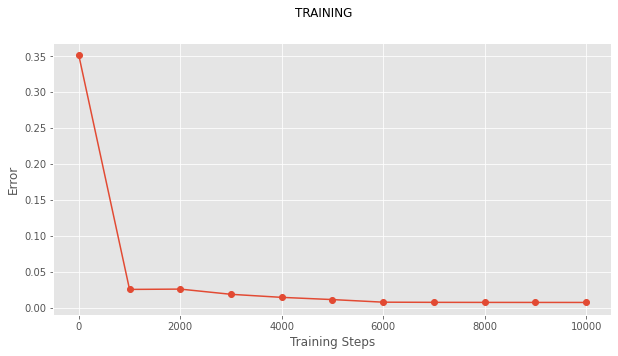

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0, 10001, 1000)

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(x, error, '-o')

plt.suptitle("TRAINING")
plt.xlabel('Training Steps')
plt.ylabel('Error')

plt.show()

In [ ]:
np.set_printoptions(formatter={'float':lambda x: '%+01.2f ' % x})

#Validation Data
for i in range(150-T):
  xv = Xv[i,:]
  y = p.forward(xv)
  yv = Yv[i,:]
  print(y.T, yv)


[[+1.00  +0.00  +0.00 ]] [+1.00  +0.00  +0.00 ]
[[+0.00  +0.01  +0.99 ]] [+0.00  +0.00  +1.00 ]
[[+0.00  +1.00  +0.00 ]] [+0.00  +1.00  +0.00 ]
[[+0.00  +1.00  +0.00 ]] [+0.00  +1.00  +0.00 ]
[[+0.00  +0.01  +0.99 ]] [+0.00  +0.00  +1.00 ]
[[+1.00  +0.01  +0.00 ]] [+1.00  +0.00  +0.00 ]
[[+0.00  +0.01  +0.99 ]] [+0.00  +0.00  +1.00 ]
[[+1.00  +0.00  +0.00 ]] [+1.00  +0.00  +0.00 ]
[[+0.00  +1.00  +0.00 ]] [+0.00  +1.00  +0.00 ]
[[+0.00  +1.00  +0.00 ]] [+0.00  +1.00  +0.00 ]
